In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_all/*" -s

finished computing metrics 
finished writing results 
runs not completed: 
	/home/enrico/ds/performance_modelling/output/test_local_planning_all/session_2022-01-17_23-14-19_588353_run_000000407
	/home/enrico/ds/performance_modelling/output/test_local_planning_all/session_2022-01-24_08-14-26_941936_run_000000158


In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 4
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [4]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]
navigation_metrics = [c for c in metrics if c in ['trajectory_length', 'execution_time', 'success_rate']]

# add metrics from existing ones
df['mean_velocity'] = df['trajectory_length'] / df['execution_time']
navigation_metrics += ['mean_velocity']
metrics += ['mean_velocity']
metrics_and_versions += ['mean_velocity']

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

## Number of Runs

    3026

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 0.75, 1.0, 1.5, 2.0, nan]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl', 'localization_generator']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['hunter', 'turtle']

    run_index                                                              [0, 1]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    controller_cpu_time                                                    min:       0.22             avg:        118             max:       1494]

    planner_cpu_time                                                       min:       0.22             avg:      33.34             max:      317.3]

    system_cpu_time                                                        min:       3.27             avg:      165.9             max:       1694]

    controller_max_memory                                                  min:      16.59             avg:      59.54             max:      78.79]

    planner_max_memory                                                     min:      16.01             avg:       1061             max:  3.109e+04]

    system_max_memory                                                      min:      116.5             avg:       1242             max:  3.126e+04]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length                                                      min:          0             avg:      20.94             max:      133.9]

    trajectory_length_version                                              [1]

    execution_time                                                         min:      0.102             avg:       90.7             max:      648.1]

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.6722             max:          1]

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   1.43e-17             avg:    0.05437             max:      4.194]

    odometry_error_alpha_1_std                                             min:          0             avg:    0.07198             max:       13.9]

    odometry_error_alpha_2_mean                                            min:  3.766e-18             avg:     0.0722             max:      9.154]

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1449             max:      18.24]

    odometry_error_alpha_3_mean                                            min:  2.061e-17             avg:    0.05913             max:     0.8207]

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01319             max:      1.417]

    odometry_error_alpha_4_mean                                            min:  1.629e-17             avg:     0.2416             max:      1.315]

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2267             max:      1.809]

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:   7.56e-05             avg:    0.09813             max:      4.113]

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.04687             max:      1.557]

    localization_update_absolute_rotation_error_mean                       min:  1.049e-06             avg:    0.02494             max:      1.273]

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.03725             max:      1.299]

    localization_update_relative_translation_error_mean                    min:  1.131e-05             avg:    0.01956             max:      2.602]

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01554             max:      1.045]

    localization_update_relative_rotation_error_mean                       min:  3.284e-07             avg:    0.01471             max:     0.8741]

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.03803             max:      1.232]

    localization_update_normalized_relative_translation_error_mean         min:    0.00547             avg:    0.07727             max:      2.643]

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.07329             max:      9.121]

    localization_update_normalized_relative_rotation_error_mean            min:   0.005356             avg:     0.1857             max:      12.29]

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.7719             max:      43.93]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:    0.09064             avg:      1.148             max:       37.4]

    localization_update_rate_std                                           min:          0             avg:     0.3956             max:      14.34]

    localization_update_rate_version                                       [1]

    mean_velocity                                                          min:          0             avg:     0.2107             max:     0.4915]

In [5]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[navigation_metrics].agg(['mean', 'count'])

trajectory_length       execution_time       success_rate       mean_velocity      
                                                                                          mean count           mean count         mean count          mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
hunter      teb                20.000                 amcl                              16.463   305         88.457   305        0.402   306         0.150   305
                               40.000                 amcl                              14.344   304         75.039   304        0.380   305         0.159   304
turtle      dwb                90.000                 amcl                              24.067   150         99.003   150        0.993   150         0.232   150
                                                      localization_generator            26.114   190        106.872   190        0.969   193         0.235   190
            rpp                90.000                 amcl                              29.448   150         83.395   150        0.636   151         0.344   150
                                                      localization_generator            25.495   150         64.582   150        0.841   151         0.362   150
            teb                20.000                 amcl                              24.457   313        117.334   313        0.725   313         0.202   313
                                                      localization_generator            22.012   282        103.453   282        0.591   308         0.197   282
                               40.000                 amcl                              23.109   312        102.702   312        0.843   313         0.222   312
                                                      localization_generator            23.458   300        102.793   300        0.789   313         0.218   300
                               90.000                 amcl                              12.184   295         51.923   295        0.565   299         0.149   295
                                                      localization_generator            19.250   179         81.092   179        0.656   224         0.227   179

Mean: 20.936755342878286


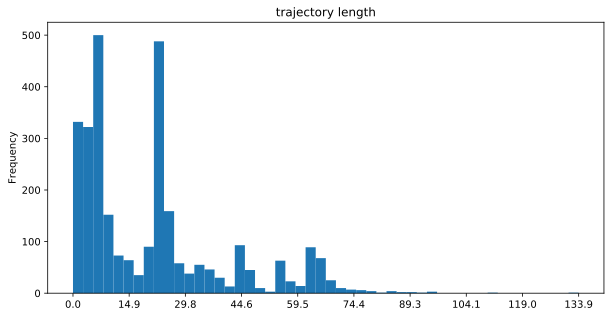

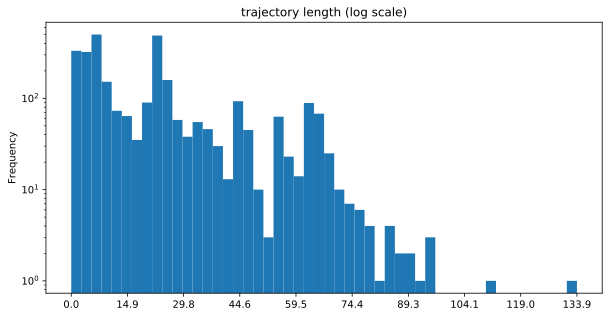

In [6]:
p = df.trajectory_length
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

Mean: 0.09812677733897612


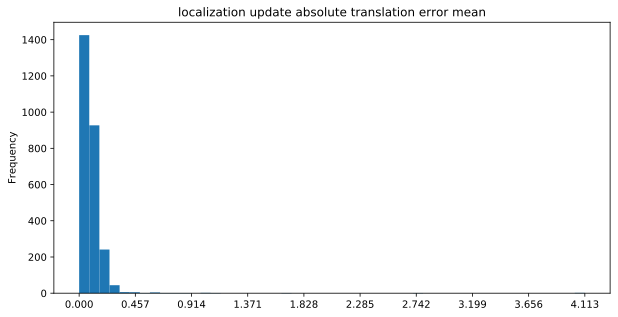

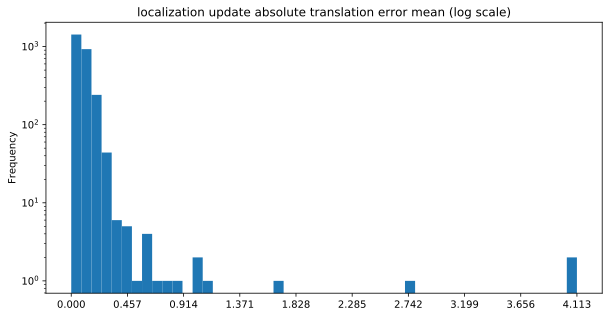

In [7]:
p = df.localization_update_absolute_translation_error_mean
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

Mean: 0.10008880082136155


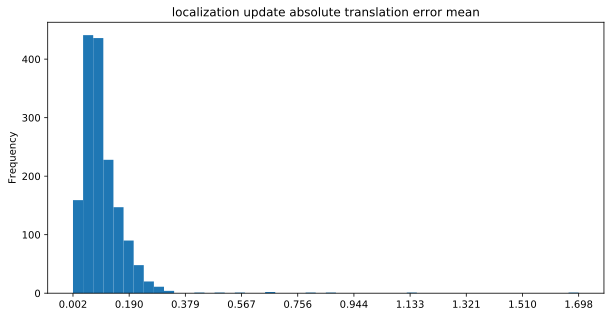

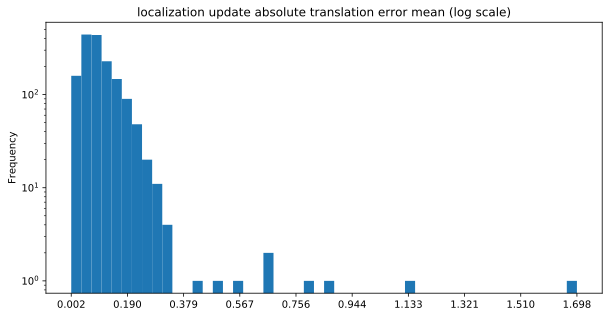

In [8]:
p = df[df.localization_node == 'amcl'].localization_update_absolute_translation_error_mean
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

Mean: 90.70197167235494


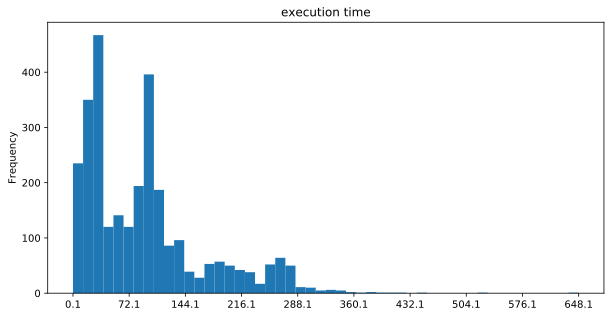

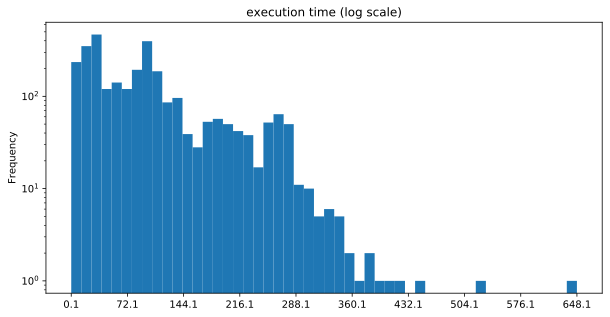

In [9]:
p = df.execution_time
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

Mean: 0.21071739259442948


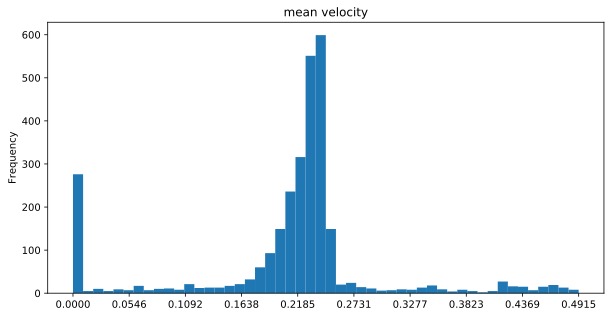

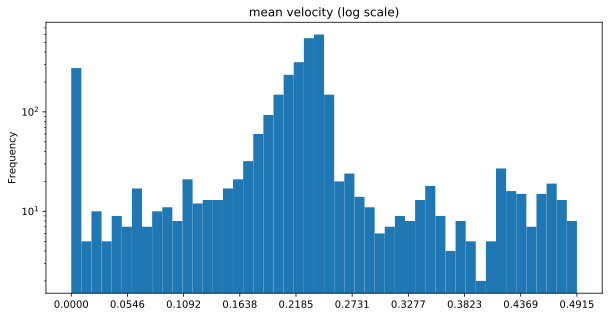

In [10]:
p = df.mean_velocity
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

mean  count
robot_model local_planner_node global_planner_node localization_node                   
turtle      rpp                navfn               amcl                   31.318     96
                                                   localization_generator 27.285    127
            dwb                navfn               localization_generator 26.106    187
                                                   amcl                   24.183    149
            teb                navfn               localization_generator 23.975    119
                                                   amcl                   23.889    133
                               smac                localization_generator  7.024     28
                                                   amcl                    5.724     36

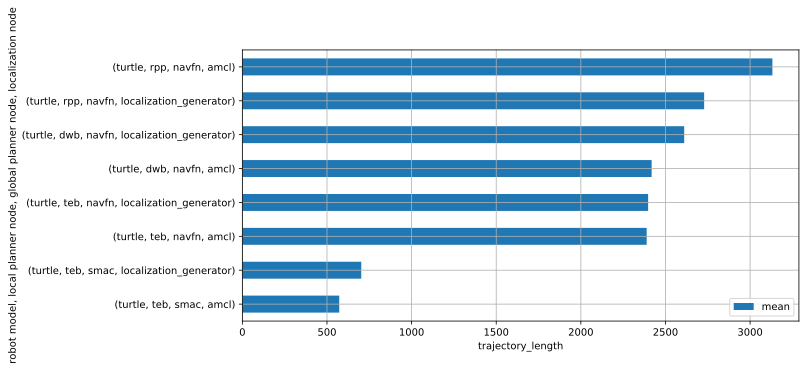

In [11]:
success_rate_df = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)].groupby([df.robot_model, df.local_planner_node, df.global_planner_node, df.localization_node])['trajectory_length'].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
ax = (success_rate_df.sort_values(by=('mean'), ascending=True)*100).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True)
ax.set_xlabel("trajectory_length")
ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
success_rate_df

mean  count
robot_model local_planner_node global_planner_node localization_node                    
turtle      dwb                navfn               localization_generator 106.814    187
            teb                navfn               localization_generator 100.845    119
                                                   amcl                   100.538    133
            dwb                navfn               amcl                    99.479    149
            rpp                navfn               amcl                    83.335     96
                                                   localization_generator  65.705    127
            teb                smac                localization_generator  29.743     28
                                                   amcl                    24.520     36

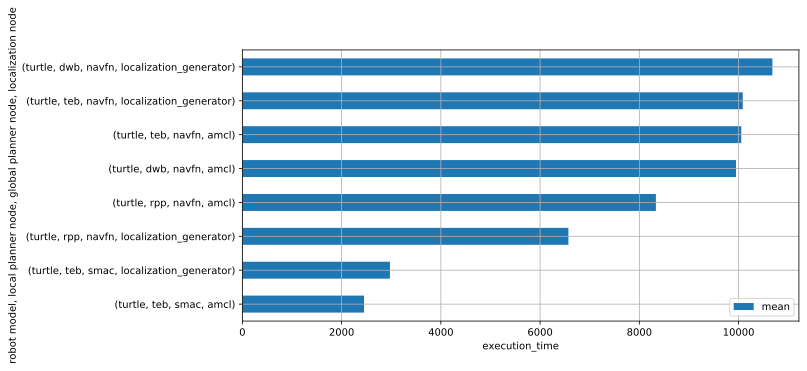

In [12]:
success_rate_df = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)].groupby([df.robot_model, df.local_planner_node, df.global_planner_node, df.localization_node])['execution_time'].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
ax = (success_rate_df.sort_values(by=('mean'), ascending=True)*100).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True)
ax.set_xlabel("execution_time")
ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
success_rate_df

mean  count
robot_model local_planner_node global_planner_node localization_node                  
turtle      rpp                navfn               localization_generator 0.362    150
                                                   amcl                   0.344    150
            dwb                navfn               localization_generator 0.235    190
            teb                navfn               amcl                   0.233    142
            dwb                navfn               amcl                   0.232    150
            teb                navfn               localization_generator 0.228    141
                               smac                localization_generator 0.224     38
                                                   amcl                   0.072    153

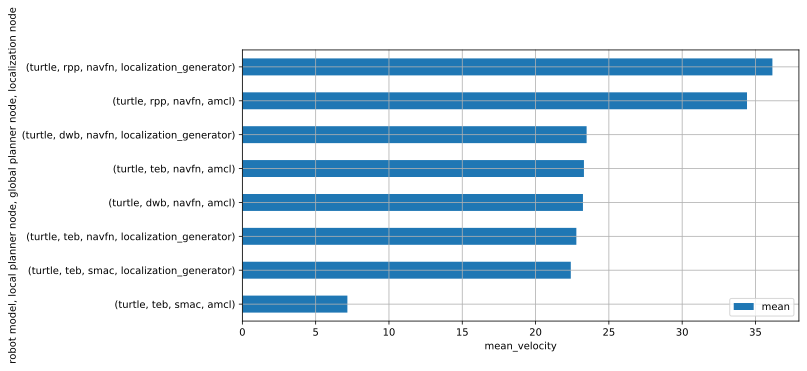

In [13]:
success_rate_df = df[df.max_steering_angle_deg == 90.0].groupby([df.robot_model, df.local_planner_node, df.global_planner_node, df.localization_node])['mean_velocity'].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
ax = (success_rate_df.sort_values(by=('mean'), ascending=True)*100).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True)
ax.set_xlabel("mean_velocity")
ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
success_rate_df

mean  count
robot_model local_planner_node global_planner_node localization_node                  
turtle      dwb                navfn               amcl                   0.993    150
                                                   localization_generator 0.969    193
            teb                navfn               amcl                   0.918    464
            rpp                navfn               localization_generator 0.841    151
            teb                navfn               localization_generator 0.825    462
            rpp                navfn               amcl                   0.636    151
hunter      teb                navfn               amcl                   0.616    297
turtle      teb                smac                localization_generator 0.509    383
                                                   amcl                   0.508    461
hunter      teb                smac                amcl                   0.178    314

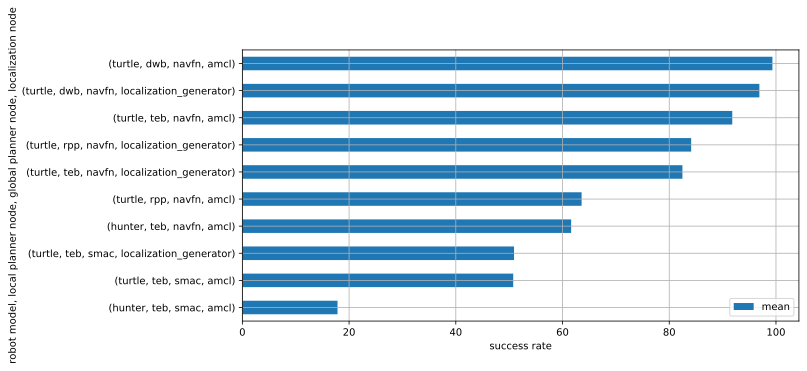

In [14]:
success_rate_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node, df.localization_node])['success_rate'].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
ax = (success_rate_df.sort_values(by=('mean'), ascending=True)*100).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True)
ax.set_xlabel("success rate")
ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
success_rate_df

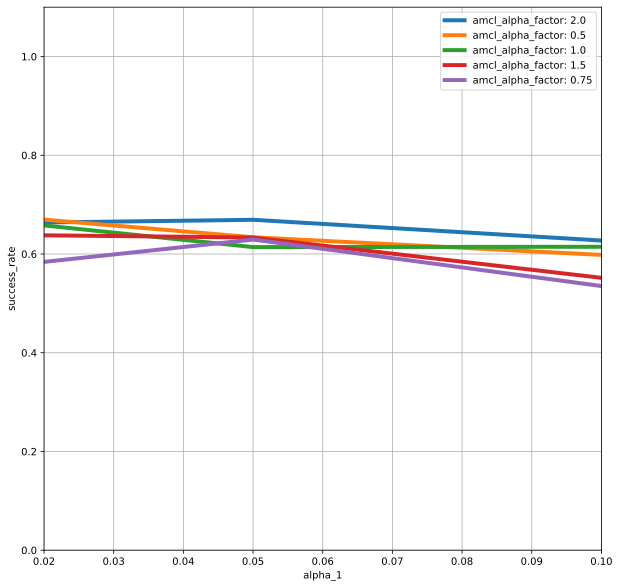

In [15]:
for amcl_alpha_factor in df[df.amcl_alpha_factor > 0].amcl_alpha_factor.unique():
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').success_rate.mean().plot(x='alpha_1', label=f"amcl_alpha_factor: {amcl_alpha_factor}", grid=True)
    plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

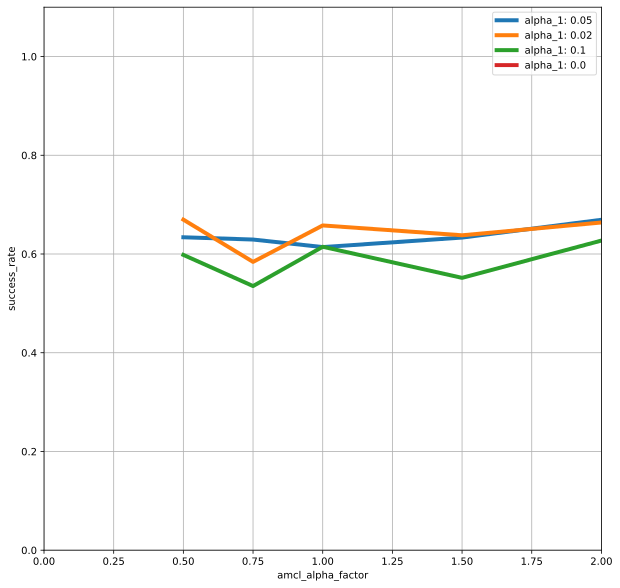

In [16]:
for alpha_1 in df.alpha_1.unique():
    df[df.alpha_1 == alpha_1].groupby('amcl_alpha_factor').success_rate.mean().plot(x='amcl_alpha_factor', label=f"alpha_1: {alpha_1}", grid=True)
    plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

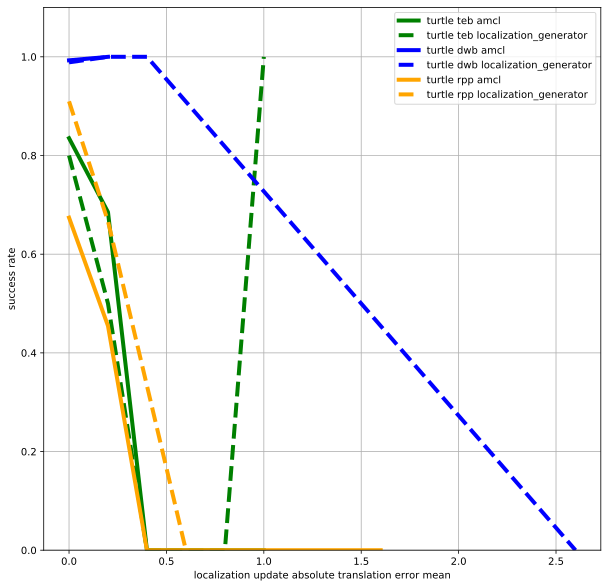

In [17]:
input_metric = df.localization_update_absolute_translation_error_mean

bins = np.arange(0., input_metric.max(), .2)

robot_model = 'turtle'
for local_planner_node in df.local_planner_node.unique():
    for localization_node in df.localization_node.unique():
        df_lr = df[(df.localization_node == localization_node) & (df.robot_model == robot_model) & (df.local_planner_node == local_planner_node) & input_metric.notna() & df.success_rate.notna()].copy()
        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
        df_lr_g = df_lr.groupby('x_range').mean()
        plt.plot(df_lr_g.index, df_lr_g.success_rate, label=f'{robot_model} {local_planner_node} {localization_node}', linestyle='--' if localization_node == 'localization_generator' else '-', color=local_planner_color[local_planner_node])

plt.legend()
plt.grid()
plt.xlabel(input_metric.name.replace('_', ' '))
plt.ylabel('success_rate'.replace('_', ' '))
plt.ylim([0, 1.1])
plt.show()

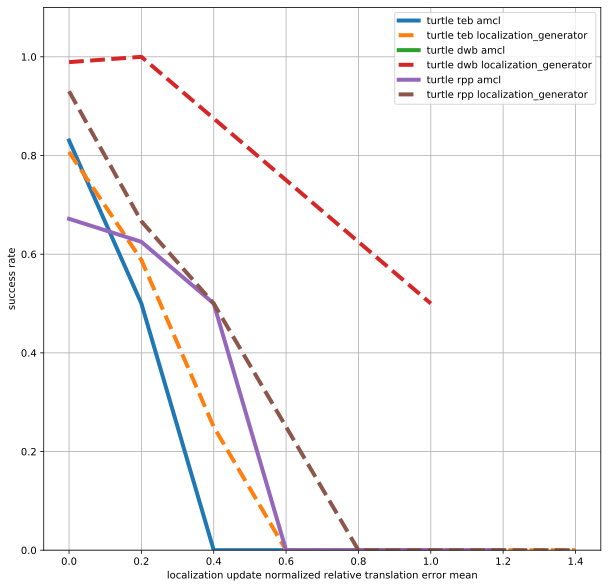

In [18]:
input_metric = df.localization_update_normalized_relative_translation_error_mean

bins = np.arange(0., input_metric.max(), .2)

robot_model = 'turtle'
for local_planner_node in df.local_planner_node.unique():
    for localization_node in df.localization_node.unique():
        df_lr = df[(df.localization_node == localization_node) & (df.robot_model == robot_model) & (df.local_planner_node == local_planner_node) & input_metric.notna() & df.success_rate.notna()].copy()
        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
        df_lr_g = df_lr.groupby('x_range').mean()
        plt.plot(df_lr_g.index, df_lr_g.success_rate, label=f'{robot_model} {local_planner_node} {localization_node}', linestyle='--' if localization_node == 'localization_generator' else '-')

plt.legend()
plt.grid()
plt.xlabel(input_metric.name.replace('_', ' '))
plt.ylabel('success_rate'.replace('_', ' '))
plt.ylim([0, 1.1])
plt.show()

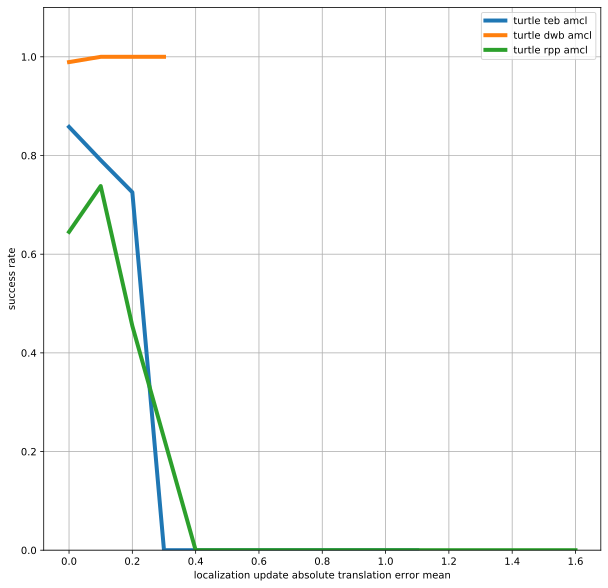

In [19]:
input_metric = df.localization_update_absolute_translation_error_mean

bins = np.arange(0., input_metric.max(), .1)

robot_model = 'turtle'
localization_node = 'amcl'
for local_planner_node in df.local_planner_node.unique():
    df_lr = df[(df.localization_node == localization_node) & (df.robot_model == robot_model) & (df.local_planner_node == local_planner_node) & input_metric.notna() & df.success_rate.notna()].copy()
    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
    df_lr_g = df_lr.groupby('x_range').mean()
    plt.plot(df_lr_g.index, df_lr_g.success_rate, label=f'{robot_model} {local_planner_node} {localization_node}', linestyle='--' if localization_node == 'localization_generator' else '-')

plt.legend()
plt.grid()
plt.xlabel(input_metric.name.replace('_', ' '))
plt.ylabel('success_rate'.replace('_', ' '))
plt.ylim([0, 1.1])
plt.show()

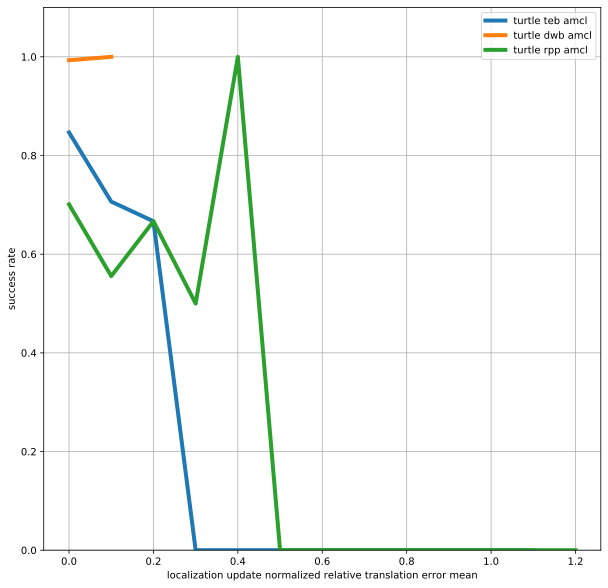

In [20]:
input_metric = df.localization_update_normalized_relative_translation_error_mean

bins = np.arange(0., input_metric.max(), .1)

robot_model = 'turtle'
localization_node = 'amcl'
for local_planner_node in df.local_planner_node.unique():
    df_lr = df[(df.localization_node == localization_node) & (df.robot_model == robot_model) & (df.local_planner_node == local_planner_node) & input_metric.notna() & df.success_rate.notna()].copy()
    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
    df_lr_g = df_lr.groupby('x_range').mean()
    plt.plot(df_lr_g.index, df_lr_g.success_rate, label=f'{robot_model} {local_planner_node} {localization_node}', linestyle='--' if localization_node == 'localization_generator' else '-')

plt.legend()
plt.grid()
plt.xlabel(input_metric.name.replace('_', ' '))
plt.ylabel('success_rate'.replace('_', ' '))
plt.ylim([0, 1.1])
plt.show()